## EUV Synoptic Map Construction with Sunpy

This notebook shows a process to produce a synoptic map of EUV data using built in `sunpy`/`astropy` capabilities as much as possible. The data is downloaded and stored in the users `sunpy.data` directory. `sunpy.map.Map.reproject_to` is used to reproject the input helioprojective data into heliographic coordinates. The co-addition of the different projected maps to form a whole sun map is then done with a function built up inline informed by archived code at https://github.com/dstansby/solarsynoptic and the example at https://docs.sunpy.org/en/stable/generated/gallery/map_transformations/reprojection_aia_euvi_mosaic.html 

In [1]:
import sys
from datetime import datetime, timedelta
from sunpy.net import Fido, attrs as a
from sunpy.coordinates.sun import L0
import sunpy.map
import astropy.units as u
import numpy as np

#### Step 1 : Data Downloads with `sunpy.net.Fido`

In [2]:
dt_most_recent = datetime(2023,2,17)
res=Fido.search(a.Time(dt_most_recent-timedelta(days=28), dt_most_recent), 
            a.Instrument.aia,
            a.Wavelength(193*u.angstrom), 
            a.Sample(24*u.hour))  
downloaded_files = Fido.fetch(res)

Files Downloaded:   0%|          | 0/28 [00:00<?, ?file/s]

#### Step 2 : Load in Data as `sunpy.map.Map` and [optional] downsample

In [3]:
downsample_dims = [1024,1024] * u.pixel
carrington_rotation = [sunpy.map.Map(m).resample(downsample_dims)  # delete `.resample...` if you don't want to downsample
                       for m in downloaded_files]

In [4]:
# ### Uncomment to view data as movie
# %matplotlib notebook
# sunpy.map.MapSequence(carrington_rotation).plot()

#### Step 3 : Do Reprojection

In [5]:
shape_out = (360, 720)
 
carrington_maps = []
for ii,m in enumerate(carrington_rotation) :
    sys.stdout.write(f"{ii+1:02d}/{len(carrington_rotation)}\r")
    header =  sunpy.map.make_heliographic_header(m.date, m.observer_coordinate, 
                                       shape_out, frame='carrington')
    carrington_maps.append(m.reproject_to(header))

In [6]:
# # Uncomment this cell to interact with the different frames
# %matplotlib inline
# from ipywidgets import interact
# def plot_carrmap(frame_index=0) : carrington_maps[frame_index].plot(
#     clip_interval=[1,100]*u.percent,
#     cmap="sdoaia193"
# )
# interact(plot_carrmap,frame_index=(0,27,1))

#### Step 4 : Combine all maps with some choice of weighting

In [7]:
ref_map = carrington_rotation[-1]
ref_date = ref_map.meta['date-obs']
ref_coord = ref_map.observer_coordinate
ref_header = sunpy.map.header_helper.make_heliographic_header(
    ref_map.date, ref_coord, shape_out, frame="carrington"
)

In [8]:
uniform_weights = [carrington_maps[0].data**0]*len(carrington_maps) ## Dumbest choice : uniform weighting

gaussian_width_lon = 60
gaussian_weights = [
    np.exp(-((sunpy.map.all_coordinates_from_map(m).lon.to("deg").value 
              -L0(m.date).to("deg").value + 180) % 360 - 180)**2
           /(2*gaussian_width_lon**2)
          ) 
    for m in carrington_maps
]

/tmp/ipykernel_368403/901324249.py:1: RuntimeWarning: Mean of empty slice
  combined_map_uniform_weights = sunpy.map.Map(np.nanmean([m.data*w for m,w in zip(carrington_maps,uniform_weights)],axis=0),ref_header)


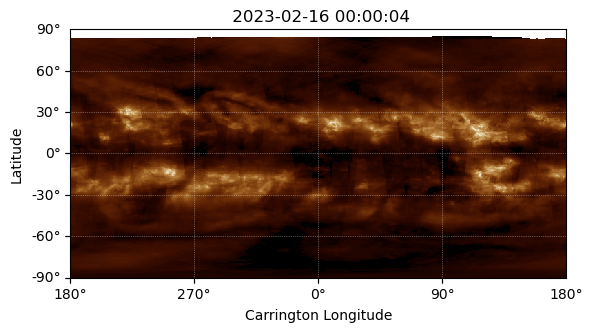

In [9]:
combined_map_uniform_weights = sunpy.map.Map(np.nanmean([m.data*w for m,w in zip(carrington_maps,uniform_weights)],axis=0),ref_header)
combined_map_uniform_weights.plot(cmap="sdoaia193",clip_interval=[3,100]*u.percent)

/tmp/ipykernel_368403/3028497015.py:1: RuntimeWarning: Mean of empty slice
  combined_map_gaussian_weights = sunpy.map.Map(np.nanmean([m.data*w for m,w in zip(carrington_maps,gaussian_weights)],axis=0),ref_header)


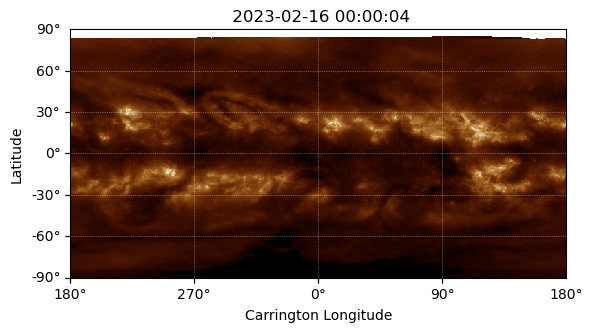

In [10]:
combined_map_gaussian_weights = sunpy.map.Map(np.nanmean([m.data*w for m,w in zip(carrington_maps,gaussian_weights)],axis=0),ref_header)
combined_map_gaussian_weights.plot(cmap="sdoaia193",clip_interval=[3,100]*u.percent)